# Basic Imports

In [1]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\Administrator/.netrc


In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

NameError: name 'teacher' is not defined

# Create teacher and student model

Both:

In [2]:
teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


Only the student or teacher:

(setting student=False will only return a single model)

In [2]:
# teacher, sampler_teacher = create_models(config_path, model_path, student=False)
student, sampler_student = create_models(config_path, model_path, student=False)

Loading model from d:\OneDrive\Uni\Master_Project_AI\Code\Diffusion_Thesis\cin_256/models/cin256_original.ckpt


c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# Loading trained student as teacher

In [2]:
model_path_test = f"{cwd}/data/trained_models/10/student_intermediate_15.pt"
teacher, sampler_teacher, optimizer, scheduler = load_trained(model_path_test, config_path)

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\pytorch_lightning\utilities\distributed.py:258: LightningDeprecationWarning: `pytorch_lightning.utilities.distributed.rank_zero_only` has been deprecated in v1.8.1 and will be removed in v2.0.0. You can import it from `pytorch_lightning.utilities` instead.
  rank_zero_deprecation(


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


## Generating WITHOUT intermediates saved

In [ ]:
img, x_T_copy, class_prompt, intermediates  = generate(teacher, sampler_teacher, steps=128, scale=3, keep_intermediates=False)
img

# Generating WITH intermediates saved

In [7]:
intermediates, starting_noise, class_prompt = return_intermediates_for_student(teacher, sampler_teacher, steps=250)

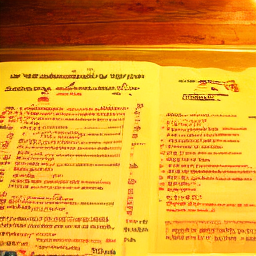

In [14]:
latent_to_img(teacher, intermediates[125])

# Creating a dataset

In [4]:
# dataset_path = f"{cwd}/data/pre_generated/teacher_128/"
# dataset_name = "teacher_128.pt"
# make_dataset(teacher, sampler_teacher, 501, 128, dataset_path, dataset_name)

100%|██████████| 500/500 [1:26:03<00:00, 10.33s/it]


# Training student from teacher directly

In [ ]:
wandb_session = wandb_log(name="test_loss", lr=1e-8, model=student, tags=["test"], notes="Just a test")

optimizer, scheduler = get_optimizer(sampler_student, iterations=20*20)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=20, generations=20, early_stop=True, session=wandb_session)

wandb.finish()

Extra, quick comparison:

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[8, 10, 12, 32])
images

In [ ]:
from util import *
import wandb
from importlib import reload


cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"


lr = 0.000001
generations = 1
steps = 2


teacher, sampler_teacher, student, sampler_student = create_models(config_path, model_path, student=True)

optimizer, scheduler = get_optimizer(sampler_student, iterations=steps*generations, lr=lr)
teacher_train_student(teacher, sampler_teacher, student, sampler_student, optimizer, scheduler, steps=steps, generations=generations, early_stop=False, session=None)

images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[32, 16, 8, 4, 2, 1])


del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

images


In [6]:
del teacher, sampler_teacher, student, sampler_student, optimizer, scheduler
torch.cuda.empty_cache()

# Train student from pre-generated teacher dataset

In [3]:
data_dir = f"{cwd}/data/pre_generated/teacher_128/"
datasets = os.listdir(data_dir)

In [ ]:
notes = """This is a serious attempt to distill the 128 step original teacher into a 64 step student, trained on 32000 instances"""
wandb_session = wandb_log(name="Train_student_on_128_pretrained", lr=0.00000001, model=student, tags=["distillation"], notes=notes)

optimizer, scheduler = get_optimizer(sampler_student, iterations=64*500)

dataset = torch.load(data_dir + datasets[0])
train_student_from_dataset(student, sampler_student, dataset, 64, optimizer, scheduler, early_stop=True, session=wandb_session)

wandb.finish()

save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

# Save and Loading trained models

In [ ]:
save_model(sampler_student, optimizer, scheduler, name="lr8_scheduled", steps=64)

In [ ]:
path = f"{cwd}/data/trained_models/64/student_lr8_scheduled.pt"
student, sampler_student, optimizer, scheduler = load_trained(path, config_path)

# Direct Comparison

In [ ]:
images, _ = compare_teacher_student(teacher, sampler_teacher, student, sampler_student, steps=[1, 2, 4, 8, 16, 32, 64, 128])
images



# Distillation Loop (allnighter)

In [ ]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2
!wandb login 4baa24c4fc6c8eed782cacb721d34977149d4fcb

ddim_steps = [128, 64, 32, 16, 8, 4, 2]
run_name = "True Attempt"
generations = 7500
lr=0.0000001
config = f"{cwd}/models/configs/cin256-v2-custom.yaml"
original_model_path = f"{cwd}/models/cin256_original.ckpt"
distill(ddim_steps, generations, run_name, config, original_model_path, lr=lr)

# x0 Prediction Models

In [42]:
from util import *
import wandb

cwd = os.getcwd()
%reload_ext autoreload
%autoreload 2

config_path=f"{cwd}/models/configs/cin256-v2-custom copy.yaml"
model_path=f"{cwd}/models/cin256_original.ckpt"

teacher, sampler_teacher = create_models(config_path, model_path, student=False)

Loading model from c:\Diffusion_Thesis\cin_256/models/cin256_original.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [64]:
# timesteps = 250
# teacher.num_timesteps= timesteps
# uc = teacher.get_learned_conditioning({teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)})
# xc = torch.tensor([992])
# c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
# img, x0 = teacher.progressive_denoising(cond=uc, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
#                               img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
#                               score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
#                               log_every_t=None)

timesteps = 600
teacher.num_timesteps= timesteps
# uc = teacher.get_learned_conditioning({teacher.cond_stage_key: torch.tensor(1*[1000]).to(teacher.device)})
xc = torch.tensor([992])
c = teacher.get_learned_conditioning({teacher.cond_stage_key: xc.to(teacher.device)})
img, x0, imgs = teacher.progressive_denoising(cond=uc, shape=[3, 64, 64], verbose=True, callback=None, quantize_denoised=False,
                              img_callback=None, mask=None, x0=None, temperature=1., noise_dropout=0.,
                              score_corrector=None, corrector_kwargs=None, batch_size=1, x_T=None, start_T=None,
                              log_every_t=None, keep_intermediates=True)

# img == x0[-1]

Progressive Generation: 100%|██████████| 600/600 [00:31<00:00, 18.97it/s]


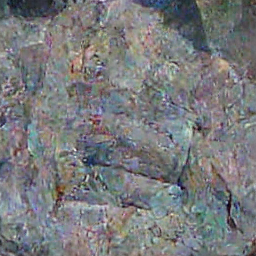

In [69]:
x_samples_ddim = teacher.decode_first_stage(imgs[-300])
# x_samples_ddim = teacher.decode_first_stage(img)
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)


# grid = torch.stack(images, 0)
grid = rearrange(x_samples_ddim, 'b c h w ->  b c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

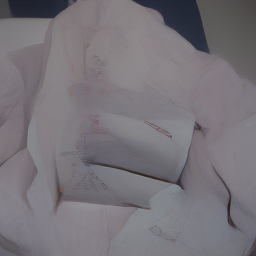

In [70]:
x_samples_ddim = teacher.decode_first_stage(x0[-300])
# x_samples_ddim = teacher.decode_first_stage(img)
x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, min=0.0, max=1.0)


# grid = torch.stack(images, 0)
grid = rearrange(x_samples_ddim, 'b c h w ->  b c h w')
grid = make_grid(grid, nrow=1)
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))

In [6]:
teacher.parameterization

'x0'